Название проекта: HR-аналитика сотрудников.

Цели: Предсказать удовлетворенность сотрудника работой и предсказать возможные увольнения из компании.

# Загрузка данных

In [1]:
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q

In [2]:
!pip install phik -q

In [3]:
!pip install shap -q

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import make_scorer
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import shap

In [5]:
job_X_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
job_X_test = pd.read_csv('/datasets/test_features.csv')
job_y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
job_X_train.name = 'job_X_train'
job_X_test.name = 'job_X_test'
job_y_test.name = 'job_y_test'

In [6]:
def describe_df(DataFrame):

    binary_feats = [col for col in DataFrame.columns if DataFrame[col].nunique() <= 2]
    categorical_feats = [col for col in DataFrame.columns if DataFrame[col].dtype == 'object' and col not in binary_feats]
    continuous_feats = [col for col in DataFrame.columns if DataFrame[col].dtype != 'object' and col not in binary_feats]

    print('Название датасета:', DataFrame.name, '\n')
    print('Бинарные переменные:', binary_feats)
    print('Категориальные переменные:', categorical_feats)
    print('Количественные переменные:', continuous_feats, '\n')

    print('Количество столбцов:', DataFrame.shape[1])
    print('Количество строк:', DataFrame.shape[0], '\n')

    print('Пропуски:\n')
    print(DataFrame.isna().sum(),'\n')
    print('Дубликаты:', DataFrame.duplicated().sum(),'\n')
    print(f'\nТипы данных: \n{DataFrame.dtypes}')

    print('Описание:\n')
    display(DataFrame.describe())
    print()

    print('Dataframe начало\n')
    display(DataFrame.head())
    print()
    print('Dataframe конец\n')
    display(DataFrame.tail())

In [7]:
describe_df(job_X_train)

Название датасета: job_X_train 

Бинарные переменные: ['last_year_promo', 'last_year_violations']
Категориальные переменные: ['dept', 'level', 'workload']
Количественные переменные: ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

Количество столбцов: 10
Количество строк: 4000 

Пропуски:

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id                         int64
dept                      object
level                     object
workload                  object
employment_years           int64
last_year_promo           object
last_year_violations      object
supervisor_evaluation      int64
salary                     int64
job_satisfaction_rate    float64
dtype: object
Описание:


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000



Dataframe начало



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Dataframe конец



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48
3999,338347,technology,middle,medium,5,no,yes,1,44400,0.18


In [8]:
describe_df(job_X_test)

Название датасета: job_X_test 

Бинарные переменные: ['last_year_promo', 'last_year_violations']
Категориальные переменные: ['dept', 'level', 'workload']
Количественные переменные: ['id', 'employment_years', 'supervisor_evaluation', 'salary'] 

Количество столбцов: 9
Количество строк: 2000 

Пропуски:

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
dtype: object
Описание:



,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000



Dataframe начало



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Dataframe конец



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400
1999,771859,purchasing,middle,medium,1,no,no,4,38400


In [9]:
describe_df(job_y_test)

Название датасета: job_y_test 

Бинарные переменные: []
Категориальные переменные: []
Количественные переменные: ['id', 'job_satisfaction_rate'] 

Количество столбцов: 2
Количество строк: 2000 

Пропуски:

id                       0
job_satisfaction_rate    0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id                         int64
job_satisfaction_rate    float64
dtype: object
Описание:



,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000



Dataframe начало



,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



Dataframe конец



,id,job_satisfaction_rate
1995,405257,0.28
1996,370925,0.21
1997,857722,0.39
1998,303402,0.26
1999,648995,0.62


Все датасеты содержат по 2000 строк, явных дубликатов не обнаружено, в job_X_train и job_X_test обнаружены пропуски, заполним их в будущем. На первый взгляд никаких аномалий не обнаружено.

# Предобработка данных

In [10]:
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [11]:
def pipe(ohe_columns, ord_columns, num_columns):
    global pipe_final
    ohe_pipe = Pipeline(
        [
            (
                'simpleImputer_ohe', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ohe', 
                OneHotEncoder(drop='first', handle_unknown='ignore')
            )
        ]
    ) 

    ord_pipe = Pipeline(
        [
            (
                'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (
                'ord',  
                OrdinalEncoder(
                    categories=[ 
                        ['junior', 'middle', 'sinior'],
                        ['low', 'medium', 'high'],
                    ], 
                    handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (
                'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )    

    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', StandardScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

    pipe_final = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', LinearRegression())
        ]
    )

In [12]:
def display_unique_values(df, column_name):
   
    if column_name in df.columns:
        unique_values = df[column_name].unique()
        print(f"Уникальные значения в столбце '{column_name}':")
        print(unique_values)
        print(f"\nОбщее количество уникальных значений: {len(unique_values)}")
    else:
        print(f"Столбец '{column_name}' не найден в DataFrame.")

display_unique_values(job_X_train, 'dept')

Уникальные значения в столбце 'dept':
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Общее количество уникальных значений: 6


In [13]:
display_unique_values(job_X_train, 'level')

Уникальные значения в столбце 'level':
['junior' 'middle' 'sinior' nan]

Общее количество уникальных значений: 4


In [15]:
display_unique_values(job_X_train, 'workload')

Уникальные значения в столбце 'workload':
['medium' 'high' 'low']

Общее количество уникальных значений: 3


In [16]:
display_unique_values(job_X_train, 'employment_years')	

Уникальные значения в столбце 'employment_years':
[ 2  1  4  7  9  6  3 10  8  5]

Общее количество уникальных значений: 10


In [17]:
display_unique_values(job_X_train, 'supervisor_evaluation')	  

Уникальные значения в столбце 'supervisor_evaluation':
[1 5 2 3 4]

Общее количество уникальных значений: 5


In [18]:
display_unique_values(job_X_train, 'salary')

Уникальные значения в столбце 'salary':
[24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]

Общее количество уникальных значений: 68


In [19]:
display_unique_values(job_X_train, 'job_satisfaction_rate')

Уникальные значения в столбце 'job_satisfaction_rate':
[0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91
 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53
 0.84 0.52 0.24 0.62 0.41 0.28 0.09 0.97 0.83 0.25 0.43 0.04 0.13 0.29
 0.95 0.93 0.87 0.08 0.94 0.07 0.34 0.9  0.12 0.06 0.96 0.05 1.   0.03]

Общее количество уникальных значений: 98


In [20]:
display_unique_values(job_X_test, 'level')

Уникальные значения в столбце 'level':
['junior' 'middle' 'sinior' nan]

Общее количество уникальных значений: 4


In [22]:
display_unique_values(job_X_test, 'dept')

Уникальные значения в столбце 'dept':
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Общее количество уникальных значений: 7


Встречаются непонятные значения ' '

In [23]:
job_X_test[job_X_test['dept'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1699,822186,,middle,medium,3,no,no,4,38400


In [24]:
display_unique_values(job_X_test, 'workload')

Уникальные значения в столбце 'workload':
['medium' 'low' 'high' ' ']

Общее количество уникальных значений: 4


Здесь аналогично встречаются непонятные значения.

In [25]:
job_X_test[job_X_test['workload'] == ' ']

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800


In [26]:
display_unique_values(job_X_test, 'supervisor_evaluation')	  

Уникальные значения в столбце 'supervisor_evaluation':
[5 4 3 1 2]

Общее количество уникальных значений: 5


In [27]:
display_unique_values(job_X_test, 'salary')

Уникальные значения в столбце 'salary':
[28800 30000 19200 40800 42000 26400 49200 62400 14400 36000 33600 44400
 27600 12000 64800 20400 34800 15600 18000 50400 31200 51600 16800 43200
 52800 32400 37200 58800 24000 21600 48000 45600 25200 63600 61200 56400
 38400 46800 55200 13200 39600 54000 57600 68400 22800 72000 81600 60000
 66000 67200 70800 76800 79200 69600 94800 82800 80400 87600 86400 96000
 78000 75600 73200 84000 88800 92400]

Общее количество уникальных значений: 66


In [28]:
job_X_train[job_X_train['dept'].isnull() | job_X_train['level'].isnull()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [29]:
nan_cols = ['dept', 'level', 'workload']
job_X_train[nan_cols] = imputer_pipe.fit_transform(job_X_train[nan_cols])

display(job_X_train[job_X_train['dept'].isnull() | job_X_train['level'].isnull()])
print(f'Количество пропущенных значений после замены: \n {job_X_train.isna().sum()}')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Количество пропущенных значений после замены: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


От явных дубликатов избавились, избавимся от пропущенных значений с помощью пайплайна.

In [30]:
imputer_pipe = Pipeline(
    [
        (
            'SimpleImputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
    ]
)

In [31]:
nan_cols = ['dept', 'level', 'workload']
job_X_train[nan_cols] = imputer_pipe.fit_transform(job_X_train[nan_cols])

display(job_X_train[job_X_train['dept'].isnull() | job_X_train['level'].isnull()])
print(f'Количество пропущенных значений после замены: \n {job_X_train.isna().sum()}')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


Количество пропущенных значений после замены: 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64


Заменили непонятные значения на NaN, чтобы обработать их пайплайном.

# Исследовательский анализ данных

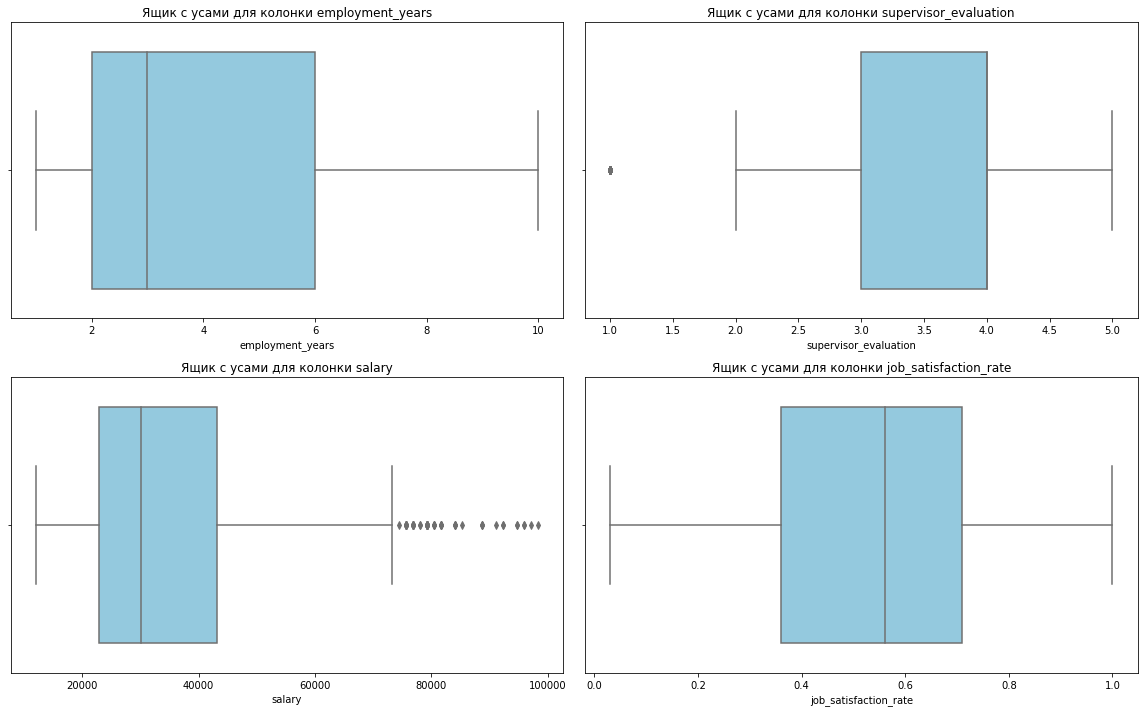

In [33]:
numerical_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

plt.figure(figsize=(16, 10))

for i, column in enumerate(numerical_columns, 1):
    if column in job_X_train.columns:
        plt.subplot(2, 2, i)
        sns.boxplot(x=job_X_train[column], color='skyblue')
        plt.title(f'Ящик с усами для колонки {column}')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

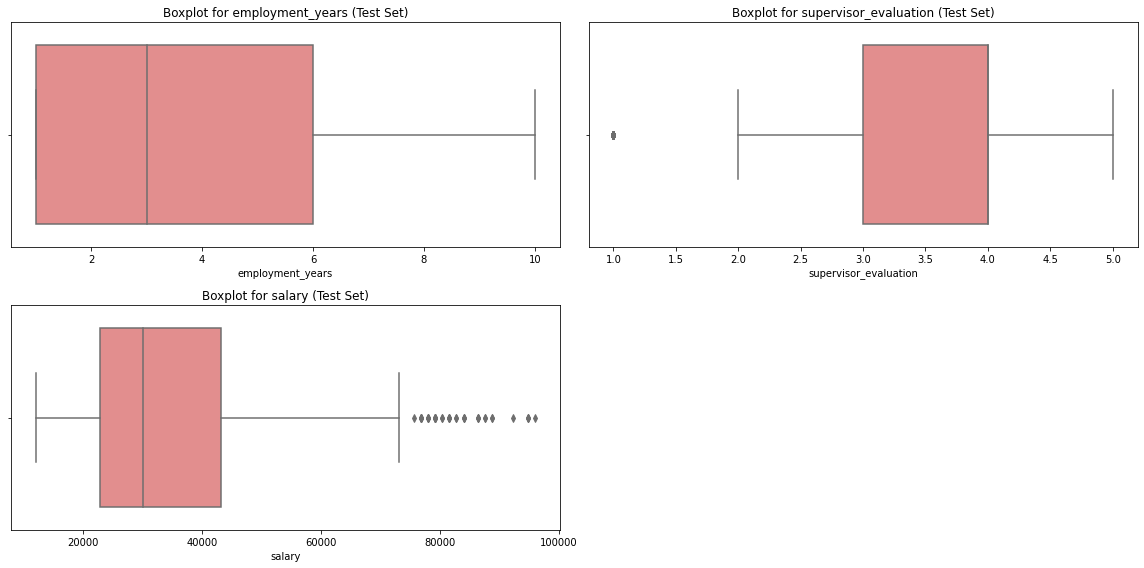

In [34]:
plt.figure(figsize=(16, 8))

for i, column in enumerate(numerical_columns, 1):
    if column in job_X_test.columns:
        plt.subplot(2, 2, i)
        sns.boxplot(x=job_X_test[column], color='lightcoral')
        plt.title(f'Boxplot for {column} (Test Set)')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

В тренировочной и тестовой выборках данные по числовым признакам, таким как стаж работы, оценка руководителя и зарплата, показали схожее распределение. В обеих выборках выбросы отсутствуют в столбце стажа работы, а значения находятся в ожидаемом диапазоне от 1 до 10 лет. В столбце оценки руководителя наблюдаются единичные выбросы при значении "1", что, вероятно, отражает реальные данные. В столбце зарплат в обеих выборках выделяются выбросы при значениях выше 60,000, что может быть связано с сотрудниками на высоких должностях.

In [35]:
job_X_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [36]:
job_X_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [37]:
job_y_test.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


В целом, можно сказать, что данные распределены равномерно в тестовой и тренировочной выборках

In [38]:
def plot_employee_data(job_X_train, job_X_test, job_y_test):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    # Распределение месячной зарплаты в обучающем и тестовом наборах
    axes[0, 0].hist(job_X_train['salary'], bins=15, color='blue', alpha=0.7)
    axes[0, 0].set_title('Ежемесячная зарплата сотрудника (train)')
    axes[0, 0].set_xlabel('Зарплата')
    axes[0, 0].set_ylabel('Частота')

    axes[0, 1].hist(job_X_test['salary'], bins=15, color='green', alpha=0.7)
    axes[0, 1].set_title('Ежемесячная зарплата сотрудника (test)')
    axes[0, 1].set_xlabel('Зарплата')
    axes[0, 1].set_ylabel('Частота')

    # Распределение уровня удовлетворенности в обучающем и тестовом наборах
    axes[1, 0].hist(job_X_train['job_satisfaction_rate'], bins=15, color='orange', alpha=0.7)
    axes[1, 0].set_title('Уровень удовлетворенности сотрудника компанией (train)')
    axes[1, 0].set_xlabel('Уровень удовлетворенности')
    axes[1, 0].set_ylabel('Частота')

    axes[1, 1].hist(job_y_test['job_satisfaction_rate'], bins=15, color='red', alpha=0.7)
    axes[1, 1].set_title('Уровень удовлетворенности сотрудника компанией (test)')
    axes[1, 1].set_xlabel('Уровень удовлетворенности')
    axes[1, 1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()


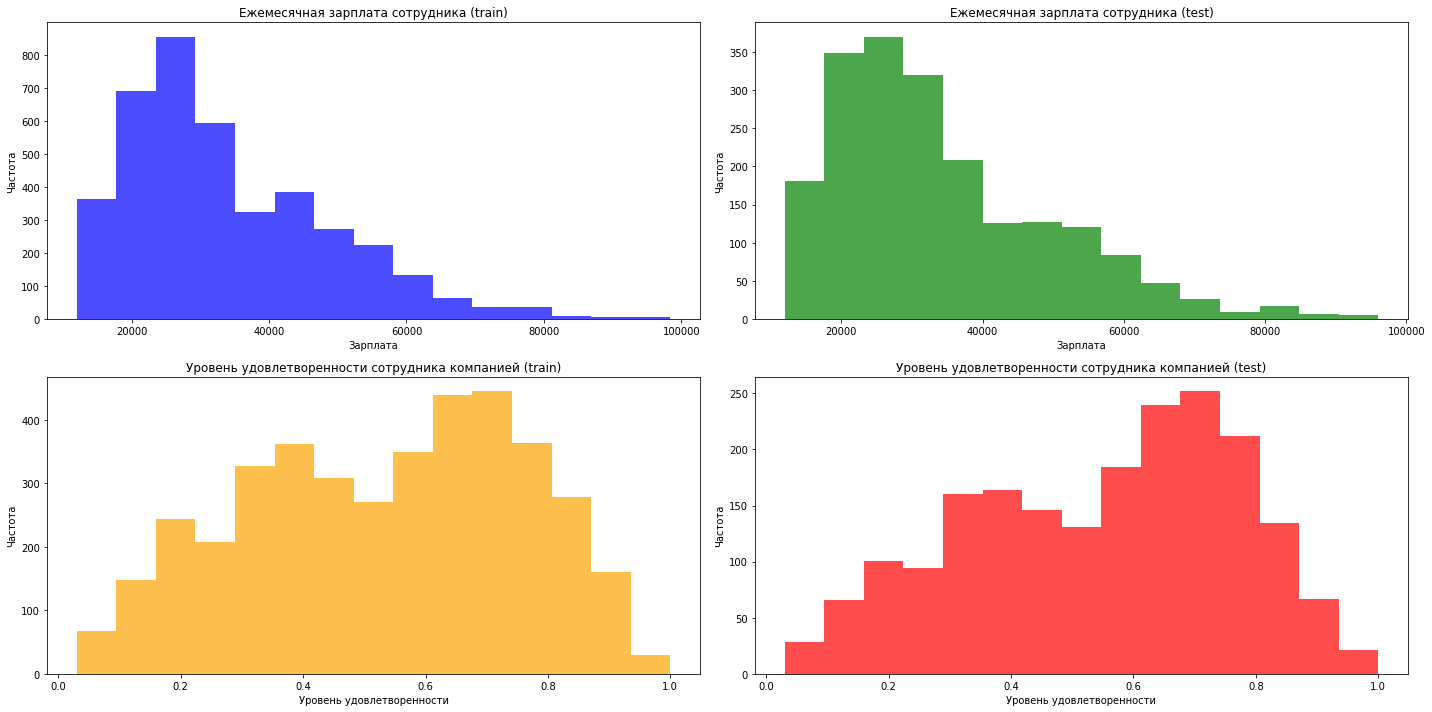

In [39]:
plot_employee_data(job_X_train, job_X_test, job_y_test)

Количественные непрерывные признаки распределены неравномерно. Для ежемесячной зарплаты сотрудников наблюдается смещение влево, а для уровня удовлетворенности сотрудников — смещение вправо. Аналогичная картина прослеживается как в тренировочной, так и в тестовой выборках. Масштабы данных значительно различаются, поэтому потребуется выполнить их нормализацию или масштабирование перед обработкой.

In [40]:
def plot_employee_data(job_X_train, job_X_test, job_y_test):
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Длительность работы в компании
    sns.countplot(x='employment_years', data=job_X_train, palette="Set1", ax=axes[0, 0]).set(
        title='Длительность работы в компании (Обучение)',
        xlabel='Годы работы', ylabel='Кол-во сотрудников'
    )

    sns.countplot(x='employment_years', data=job_X_test, palette="Set1", ax=axes[0, 1]).set(
        title='Длительность работы в компании (Тест)',
        xlabel='Годы работы', ylabel='Кол-во сотрудников'
    )

    # Оценка качества работы сотрудника
    sns.countplot(x='supervisor_evaluation', data=job_X_train, palette="Set1", ax=axes[1, 0]).set(
        title='Оценка качества работы сотрудника (Обучение)',
        xlabel='Оценка', ylabel='Кол-во сотрудников'
    )

    sns.countplot(x='supervisor_evaluation', data=job_X_test, palette="Set1", ax=axes[1, 1]).set(
        title='Оценка качества работы сотрудника (Тест)',
        xlabel='Оценка', ylabel='Кол-во сотрудников'
    )

    plt.tight_layout()
    plt.show()

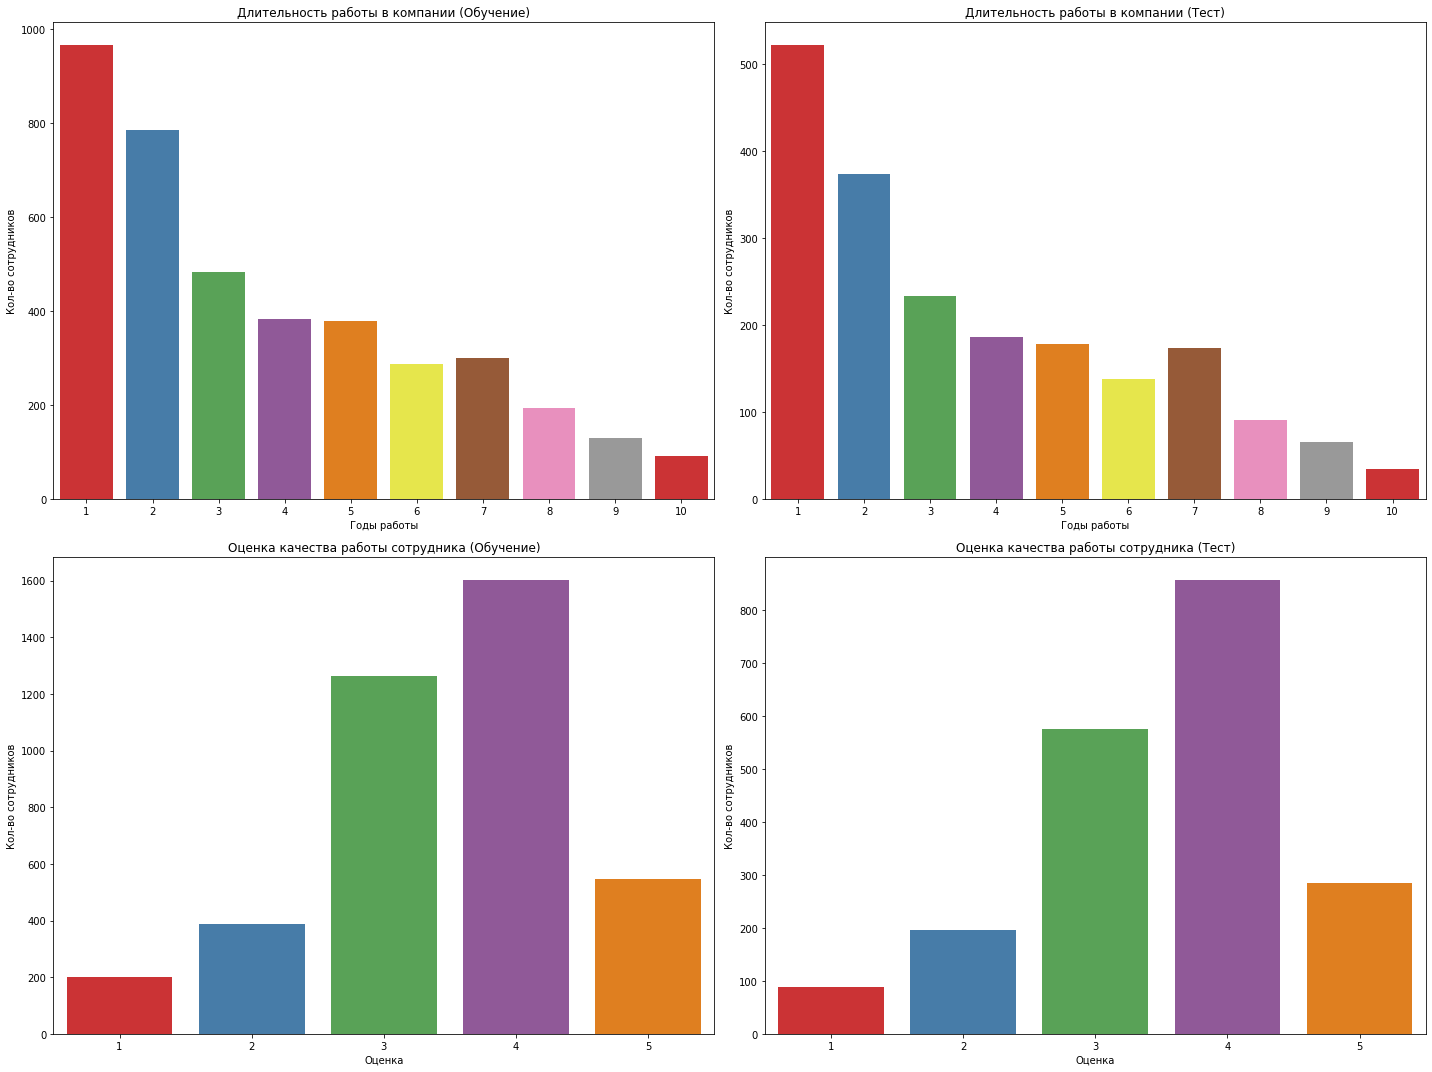

In [42]:
# columns_to_plot = ['employment_years', 'supervisor_evaluation']
plot_employee_data(job_X_train, job_X_test, job_y_test)
# plot_pie_comparison(job_X_train, job_X_test, columns_to_plot , title='Распределение характеристик сотрудников', ylabel='Процент')

Большинство сотрудников работает в компании один год, и с увеличением количества лет в компании их число уменьшается. Среди оценок сотрудников чаще всего встречаются значения 3 и 4. Распределение в тренировочной и тестовой выборках выглядит примерно одинаково.

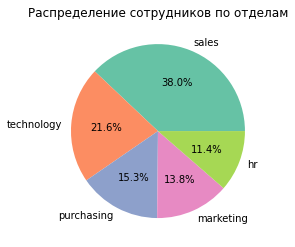

In [43]:
plt.pie(
    job_X_train['dept'].value_counts(),
    labels=['sales',
            'technology',
            'purchasing',
            'marketing',
            'hr',
            ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2')
)
plt.title('Распределение сотрудников по отделам')
plt.grid()
plt.show()

Видим, что более 50% сотрудников работают в сфере технологий и в отделе продаж, в покупках, HR, маркетинге работают меньше людей.

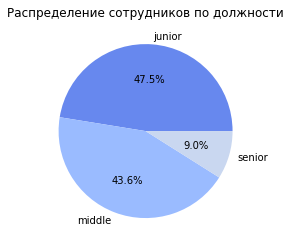

In [44]:
plt.pie(
    job_X_train['level'].value_counts(),
    labels=[
        'junior',
        'middle',
        'senior',
    ],
    autopct='%1.1f%%',
    colors=sns.color_palette('coolwarm')
)
plt.title('Распределение сотрудников по должности')
plt.grid()
plt.show()

Большая часть сотрудников является junior-специалистами, что характерно для стандартной ситуации, однако мидлов тоже достаточно много

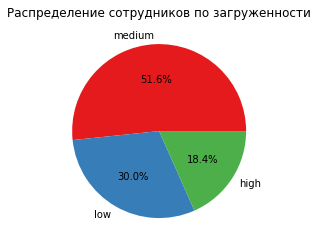

In [45]:
plt.pie(
    job_X_train['workload'].value_counts(),
    labels=[
        'medium',
        'low',
        'high',
    ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set1')
)
plt.title('Распределение сотрудников по загруженности')
plt.grid()
plt.show()

По загруженности мы наблюдаем, что больше половины имеют среднюю загруженность, 30% сотрудников-маленькую. В целом, достаточно хорошая ситуация.

# Корреляционный анализ

In [46]:
data=job_X_train.set_index('id')

In [47]:
interval_cols = ['salary', 'job_satisfaction_rate']
phik_overview = phik_matrix(data,interval_cols=interval_cols)

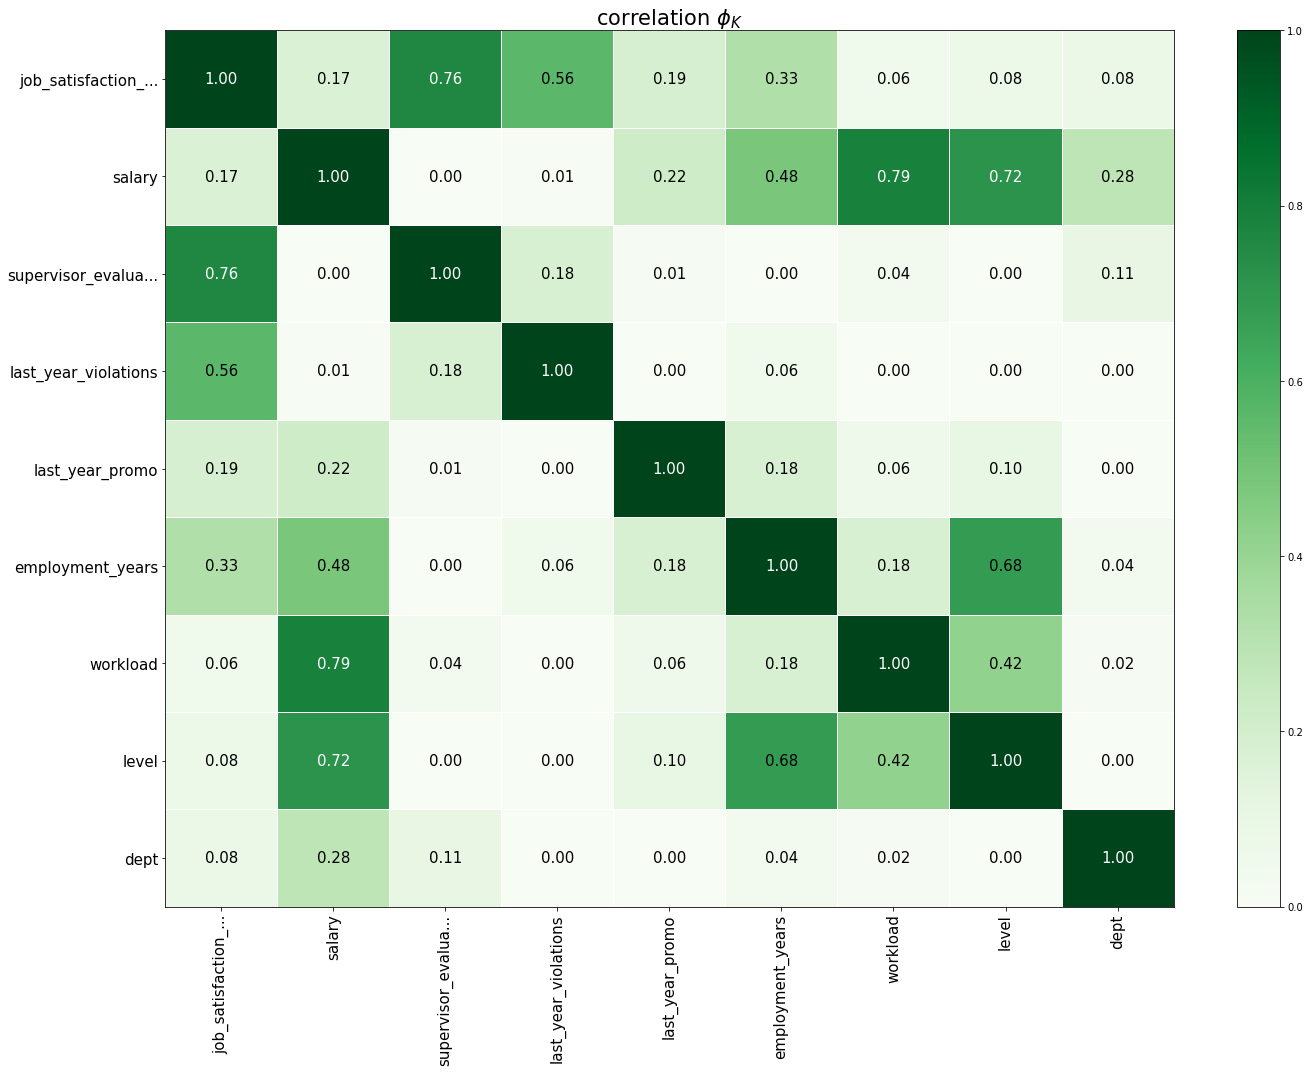

In [48]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Мультиколлинеарности не обнаружено, наблюдаются умеренные линейные связи между несколькими показателями. Утечки целевого признака также не обнаружено

Мы провели исследовательский анализ данных и изучили их распределение во всех таблицах. По итогам анализа можно сделать вывод, что данные выглядят достоверно, значительных выбросов не выявлено, а при корреляционном анализе утечек целевого признака обнаружено не было. Перед обучением модели необходимо будет подготовить данные, включив масштабирование числовых признаков, кодирование категориальных переменных и обработку пропусков в пайплайне.

Подготовка данных

In [49]:
train_temp = job_X_train.drop(['id'], axis=1)
print('Количество дубликатов:',train_temp.duplicated().sum())

Количество дубликатов: 248


In [50]:
train_temp = train_temp.drop_duplicates().reset_index(drop=True)

In [51]:
X_train = train_temp.drop(['job_satisfaction_rate'], axis=1)
y_train = train_temp['job_satisfaction_rate']

In [52]:
X_train.shape

(3752, 8)

In [53]:
test = job_X_test.merge(job_y_test, on='id')

In [54]:
X_test_ = test.drop(['job_satisfaction_rate','id'], axis=1)
y_test_ = test['job_satisfaction_rate']
X_test_.shape

(2000, 8)

In [55]:
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
ord_columns = ['level', 'workload' ]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation'] 

In [56]:
pipe(ohe_columns, ord_columns, num_columns)

Данные подготовлены с помощью пайплайна, выделяем определенные категории столбцов для преобразований.

# Обучение модели

In [57]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=42)],
        'models__max_depth': range(1, 21),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
 
    {
        'models': [LinearRegression()]
    }
]

In [58]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))

Вводим свою метрику

In [59]:
smape_scorer = make_scorer(smape, greater_is_better=False)

In [60]:
grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=10,
    scoring=smape_scorer,
    n_jobs=-1,
)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['last_year_violations',
                                                                          'last_year_promo',
                                                                          'dept']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImpu...
             param_grid=[{'models': [DecisionTreeRegressor(max_depth=17,
                                                           min_samples_leaf=3,
                                                           random_state=42)],
                          'models__max_depth': range(1, 21),
                          'models__min_samples_leaf': range(1, 6),
                          'models__min_samples_split': range(2, 6),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()]}],
             scoring=make_scorer(smape, greater_is_better=False))

In [61]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', grid.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [62]:
y_pred_test = grid.best_estimator_.predict(X_test_)
smape_test = smape(y_test_, y_pred_test)
print ("Метрика SMAPE равна:", smape_test)

Метрика SMAPE равна: 13.450319840406276


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  return output


Модель удовлетворяет наши ожидания, значение метрики на тестовой выборке 13.72, лучшей моделью оказалась DecisionTreeRegressor(max_depth=16, min_samples_leaf=5)

# Общие выводы


Мы успешно выполнили первую задачу: разработали модель, способную прогнозировать уровень удовлетворённости сотрудников на основе предоставленных данных.

В процессе работы обучили несколько моделей и выбрали оптимальную на основании метрики SMAPE. Лучшими результатами отличилась модель дерева решений с максимальной глубиной 16 и количеством признаков для поиска оптимального разбиения равным 5. Метрика на тестовой выборке лучше, чем на тренировочной, но она удовлетворяет критерием, так что модель можно считать успешной.

Скорее всего, дерево решений превзошло линейную регрессию благодаря большей гибкости в настройке гиперпараметров.

# Задача 2

# Загрузка данных

In [63]:
quit_X_train = pd.read_csv('/datasets/train_quit.csv')
quit_y_test = pd.read_csv('/datasets/test_target_quit.csv')
quit_X_train.name = 'quit_X_train'
quit_y_test.name = 'quit_y_test'

In [64]:
describe_df(quit_X_train)

Название датасета: quit_X_train 

Бинарные переменные: ['last_year_promo', 'last_year_violations', 'quit']
Категориальные переменные: ['dept', 'level', 'workload']
Количественные переменные: ['id', 'employment_years', 'supervisor_evaluation', 'salary'] 

Количество столбцов: 10
Количество строк: 4000 

Пропуски:

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id                        int64
dept                     object
level                    object
workload                 object
employment_years          int64
last_year_promo          object
last_year_violations     object
supervisor_evaluation     int64
salary                    int64
quit                     object
dtype: object
Описание:



,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000



Dataframe начало



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



Dataframe конец



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no
3999,853842,sales,junior,medium,2,no,no,3,27600,yes


В тренировочной выборке 4000 значений, явных дубликатов и пропусков не обнаружено.

In [65]:
describe_df(quit_y_test)

Название датасета: quit_y_test 

Бинарные переменные: ['quit']
Категориальные переменные: []
Количественные переменные: ['id'] 

Количество столбцов: 2
Количество строк: 2000 

Пропуски:

id      0
quit    0
dtype: int64 

Дубликаты: 0 


Типы данных: 
id       int64
quit    object
dtype: object
Описание:



,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000



Dataframe начало



,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



Dataframe конец



,id,quit
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no
1999,460332,yes


В датасете целевого признака тестовой выборке 2000 значений, с ними все в порядке

# Предобработка данных

In [66]:
display_unique_values(job_X_train, 'dept')

Уникальные значения в столбце 'dept':
['sales' 'hr' 'technology' 'purchasing' 'marketing']

Общее количество уникальных значений: 5


In [67]:
display_unique_values(quit_X_train, 'level')

Уникальные значения в столбце 'level':
['middle' 'junior' 'sinior']

Общее количество уникальных значений: 3


In [68]:
quit_X_train['level'] = quit_X_train['level'].replace('sinior', 'senior')

In [69]:
display_unique_values(quit_X_train, 'workload')

Уникальные значения в столбце 'workload':
['high' 'medium' 'low']

Общее количество уникальных значений: 3


In [70]:
display_unique_values(quit_X_train, 'employment_years')

Уникальные значения в столбце 'employment_years':
[ 2  5  1  8  4  7  3  9  6 10]

Общее количество уникальных значений: 10


In [71]:
display_unique_values(quit_X_train, 'supervisor_evaluation')

Уникальные значения в столбце 'supervisor_evaluation':
[4 1 3 5 2]

Общее количество уникальных значений: 5


In [72]:
display_unique_values(job_X_train, 'salary')

Уникальные значения в столбце 'salary':
[24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200]

Общее количество уникальных значений: 68


In [73]:
display_unique_values(quit_X_train, 'quit')

Уникальные значения в столбце 'quit':
['no' 'yes']

Общее количество уникальных значений: 2


# Исследовательский анализ данных

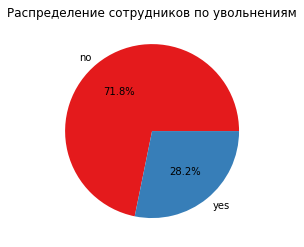

In [74]:
plt.pie(
    quit_X_train['quit'].value_counts(),
    labels=[
        'no',
        'yes',
    ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set1')
)
plt.title('Распределение сотрудников по увольнениям')
plt.grid()
plt.show()

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b  </b></u></font> Наблюдается дисбаланс в целевой переменной. Это отражается плохо на метрике, accuracy, например, она не сможет предсказывать данные для минорного класса. Чтобы справиться с дисбалансом, нужно использовать такие метрики, как: roc-auc, precision, recall, f1-score.
    <br />

Более четверти сотрудников уволилось. Это катастрофически большие значения.

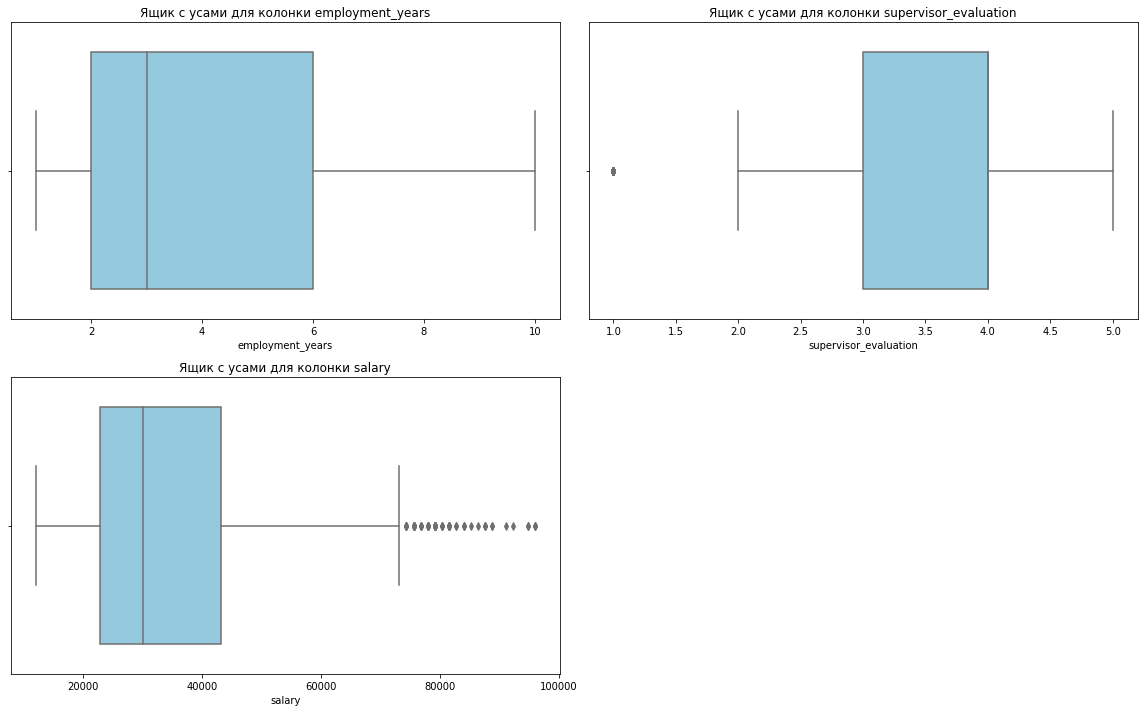

In [75]:
numerical_columns = ['employment_years', 'supervisor_evaluation', 'salary']

plt.figure(figsize=(16, 10))

for i, column in enumerate(numerical_columns, 1):
    if column in quit_X_train.columns:
        plt.subplot(2, 2, i)
        sns.boxplot(x=quit_X_train[column], color='skyblue')
        plt.title(f'Ящик с усами для колонки {column}')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

In [76]:
quit_X_train.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [77]:
quit_y_test.describe()

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


In [78]:
def plot_employee_data(quit_X_train, job_X_test, quit_y_test):
    fig, axes = plt.subplots(2, 2, figsize=(20, 10))

    # Распределение месячной зарплаты в обучающем и тестовом наборах
    axes[0, 0].hist(job_X_train['salary'], bins=15, color='blue', alpha=0.7)
    axes[0, 0].set_title('Ежемесячная зарплата сотрудника (train)')
    axes[0, 0].set_xlabel('Зарплата')
    axes[0, 0].set_ylabel('Частота')

    axes[0, 1].hist(job_X_test['salary'], bins=15, color='green', alpha=0.7)
    axes[0, 1].set_title('Ежемесячная зарплата сотрудника (test)')
    axes[0, 1].set_xlabel('Зарплата')
    axes[0, 1].set_ylabel('Частота')

    # Распределение уровня удовлетворенности в обучающем и тестовом наборах
    axes[1, 0].hist(job_X_train['job_satisfaction_rate'], bins=15, color='orange', alpha=0.7)
    axes[1, 0].set_title('Уровень удовлетворенности сотрудника компанией (train)')
    axes[1, 0].set_xlabel('Уровень удовлетворенности')
    axes[1, 0].set_ylabel('Частота')

    axes[1, 1].hist(job_y_test['job_satisfaction_rate'], bins=15, color='red', alpha=0.7)
    axes[1, 1].set_title('Уровень удовлетворенности сотрудника компанией (test)')
    axes[1, 1].set_xlabel('Уровень удовлетворенности')
    axes[1, 1].set_ylabel('Частота')

    plt.tight_layout()
    plt.show()


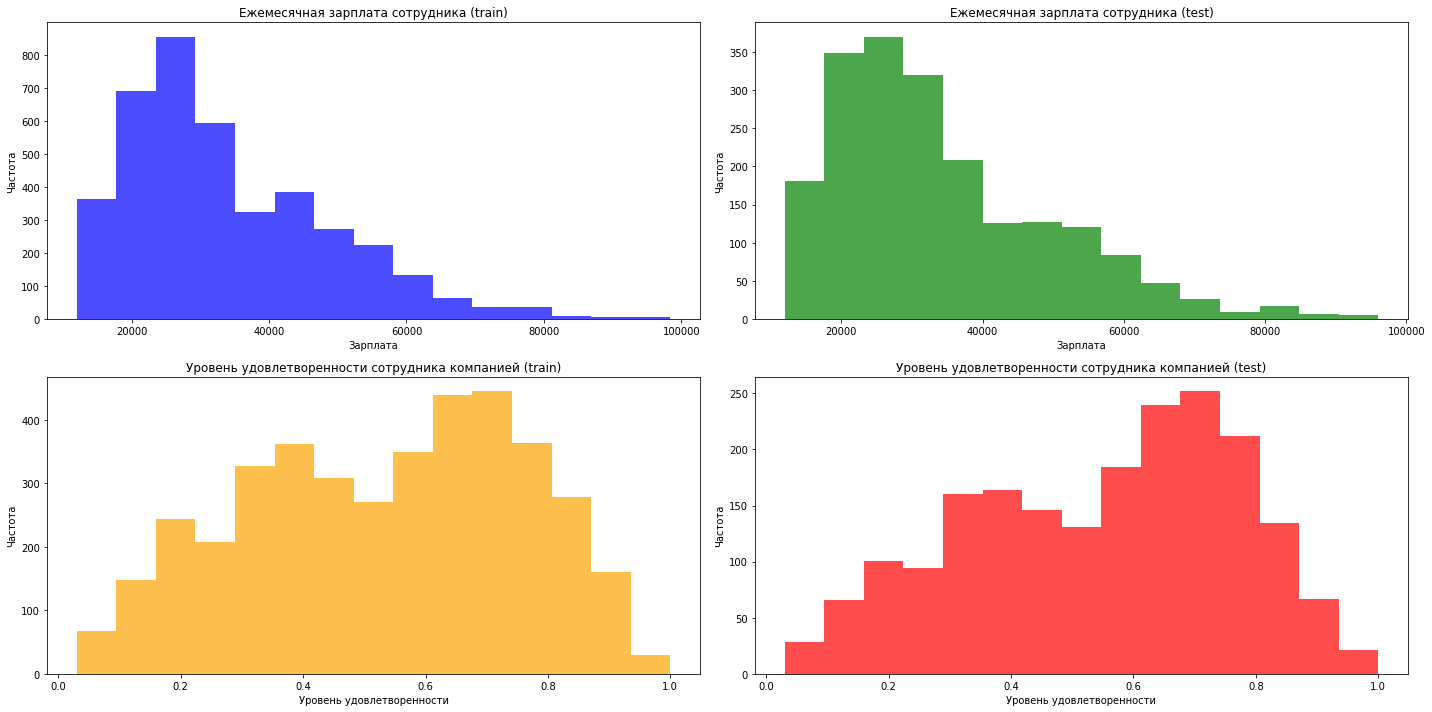

In [79]:
plot_employee_data(quit_X_train, job_X_test, quit_y_test)

In [80]:
def plot_employee_data(job_X_train, job_X_test, job_y_test):
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))

    # Длительность работы в компании
    sns.countplot(x='employment_years', data=quit_X_train, palette="Set1", ax=axes[0, 0]).set(
        title='Длительность работы в компании (Обучение)',
        xlabel='Годы работы', ylabel='Кол-во сотрудников'
    )

    sns.countplot(x='employment_years', data=job_X_test, palette="Set1", ax=axes[0, 1]).set(
        title='Длительность работы в компании (Тест)',
        xlabel='Годы работы', ylabel='Кол-во сотрудников'
    )

    # Оценка качества работы сотрудника
    sns.countplot(x='supervisor_evaluation', data=quit_X_train, palette="Set1", ax=axes[1, 0]).set(
        title='Оценка качества работы сотрудника (Обучение)',
        xlabel='Оценка', ylabel='Кол-во сотрудников'
    )

    sns.countplot(x='supervisor_evaluation', data=job_X_test, palette="Set1", ax=axes[1, 1]).set(
        title='Оценка качества работы сотрудника (Тест)',
        xlabel='Оценка', ylabel='Кол-во сотрудников'
    )

    plt.tight_layout()
    plt.show()


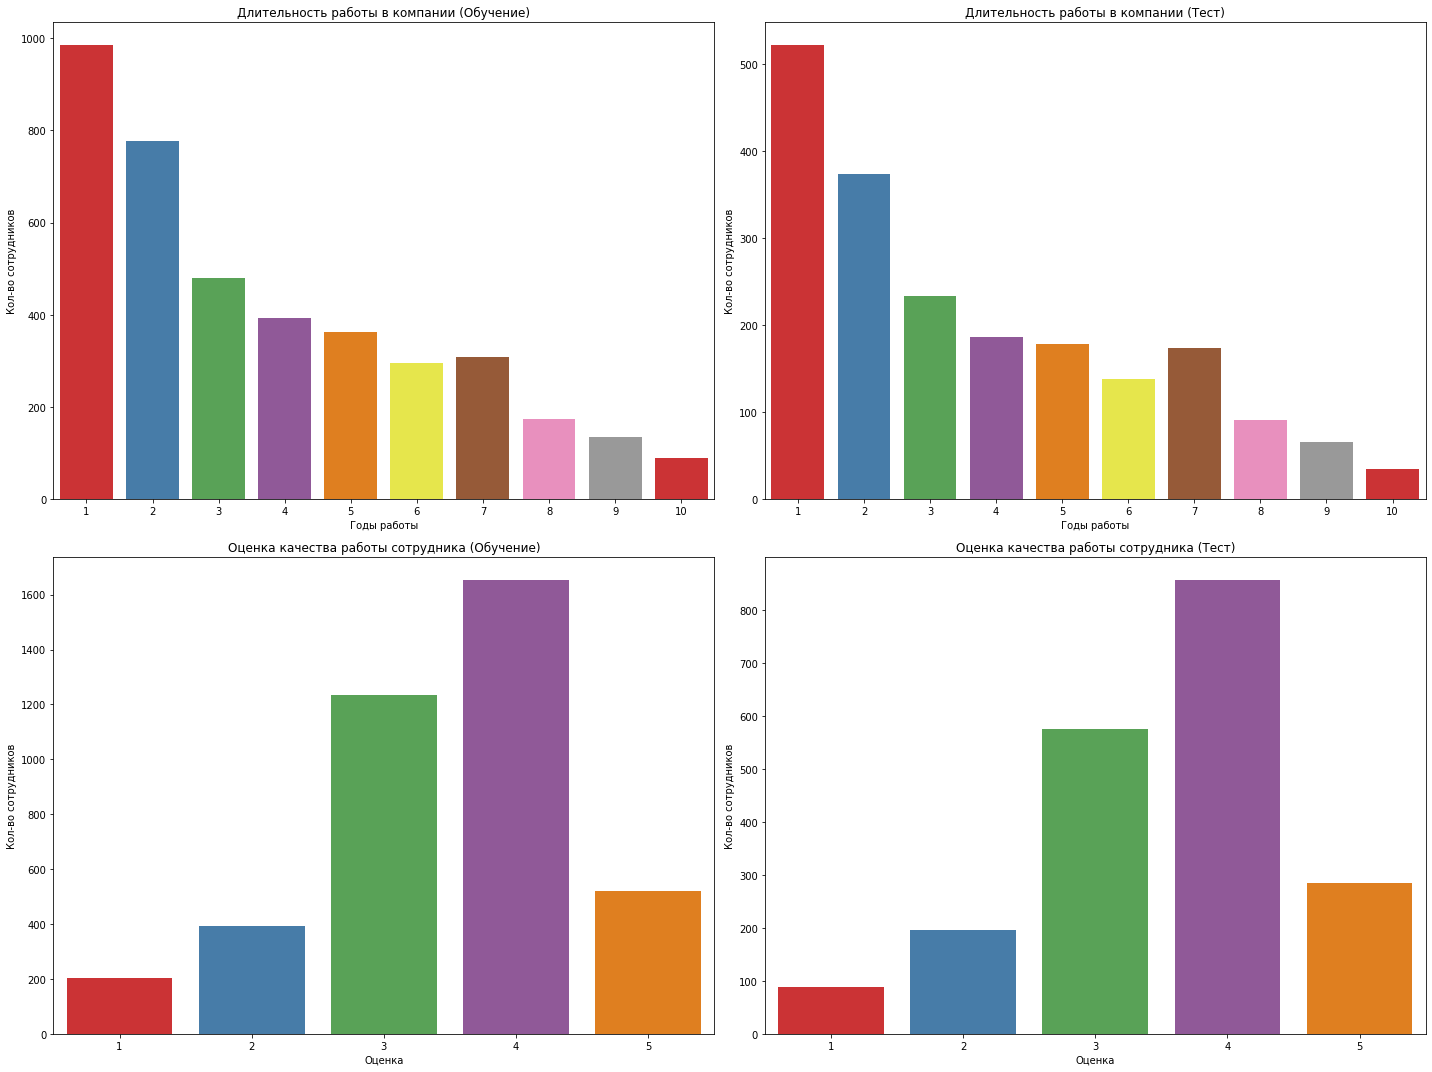

In [81]:
plot_employee_data(quit_X_train, job_X_test, quit_y_test)

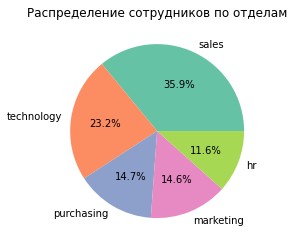

In [82]:
plt.pie(
    quit_X_train['dept'].value_counts(),
    labels=['sales',
            'technology',
            'purchasing',
            'marketing',
            'hr',
            ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2')
)
plt.title('Распределение сотрудников по отделам')
plt.grid()
plt.show()

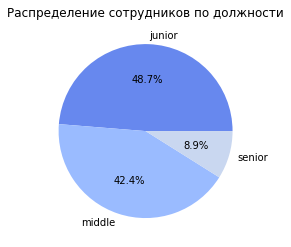

In [83]:
plt.pie(
    quit_X_train['level'].value_counts(),
    labels=[
        'junior',
        'middle',
        'senior',
    ],
    autopct='%1.1f%%',
    colors=sns.color_palette('coolwarm')
)
plt.title('Распределение сотрудников по должности')
plt.grid()
plt.show()

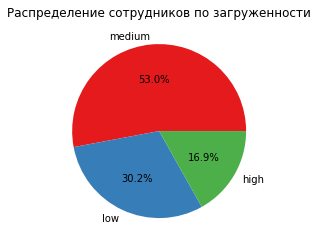

In [84]:
plt.pie(
    quit_X_train['workload'].value_counts(),
    labels=[
        'medium',
        'low',
        'high',
    ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set1')
)
plt.title('Распределение сотрудников по загруженности')
plt.grid()
plt.show()

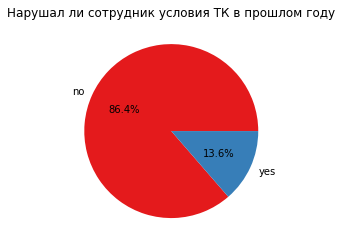

In [85]:
plt.pie(
    quit_X_train['last_year_violations'].value_counts(),
    labels=['no',
            'yes'
            ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set1')
)
plt.title('Нарушал ли сотрудник условия ТК в прошлом году')
plt.grid()
plt.show()

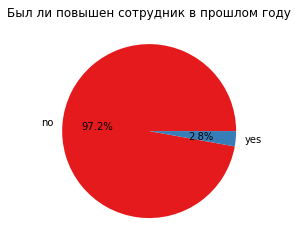

In [86]:
plt.pie(
    quit_X_train['last_year_promo'].value_counts(),
    labels=['no',
            'yes'
            ],
    autopct='%1.1f%%',
    colors=sns.color_palette('Set1')
)
plt.title('Был ли повышен сотрудник в прошлом году')
plt.grid()
plt.show()

Проведя исследовательский анализ, мы понимаем, что распределение новой тренировочной выборки практически не отличается от предыдущей, поэтому никаких конфликтов не должно быть.

In [87]:
data_q=quit_X_train.set_index('id')
data_q_not_resigned = data_q[data_q['quit'] == 'no']
data_q_resigned = data_q[data_q['quit'] == 'yes']

In [88]:
interval_cols = ['salary']
phik_overview = phik_matrix(data_q,interval_cols=interval_cols)

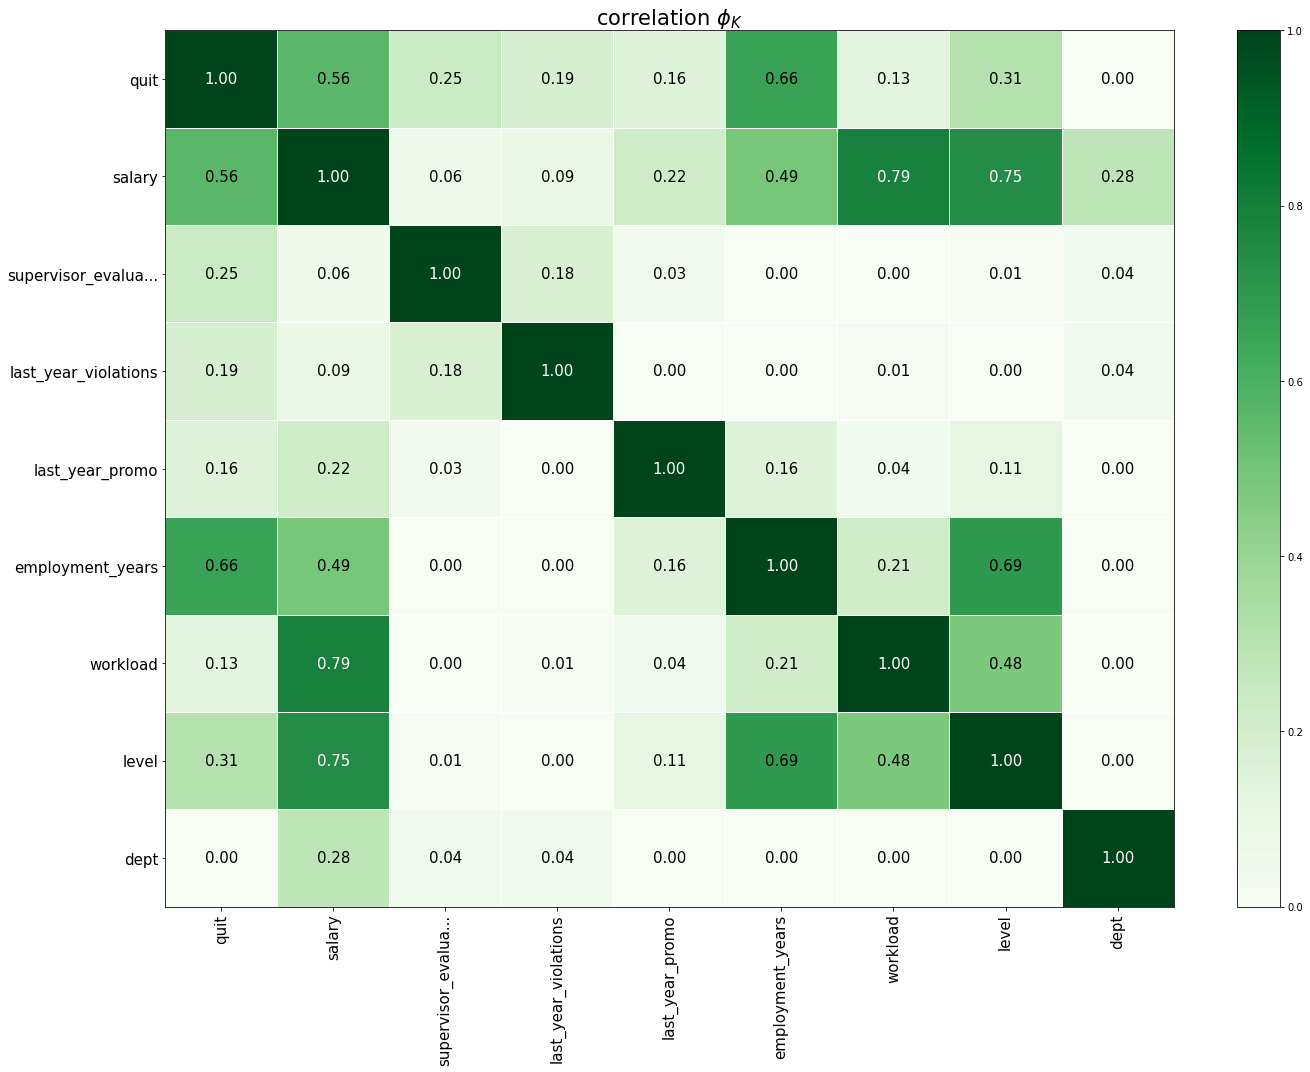

In [89]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

In [90]:
phik_overview = phik_matrix(data_q_not_resigned,interval_cols=interval_cols)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


In [91]:
data_q_not_resigned

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
910140,marketing,junior,medium,2,no,no,5,25200,no
417070,technology,middle,medium,8,no,no,2,44400,no
...,...,...,...,...,...,...,...,...,...
106936,marketing,junior,low,1,no,no,5,18000,no
387733,marketing,middle,medium,5,no,no,3,44400,no
588809,sales,junior,medium,4,no,no,3,26400,no


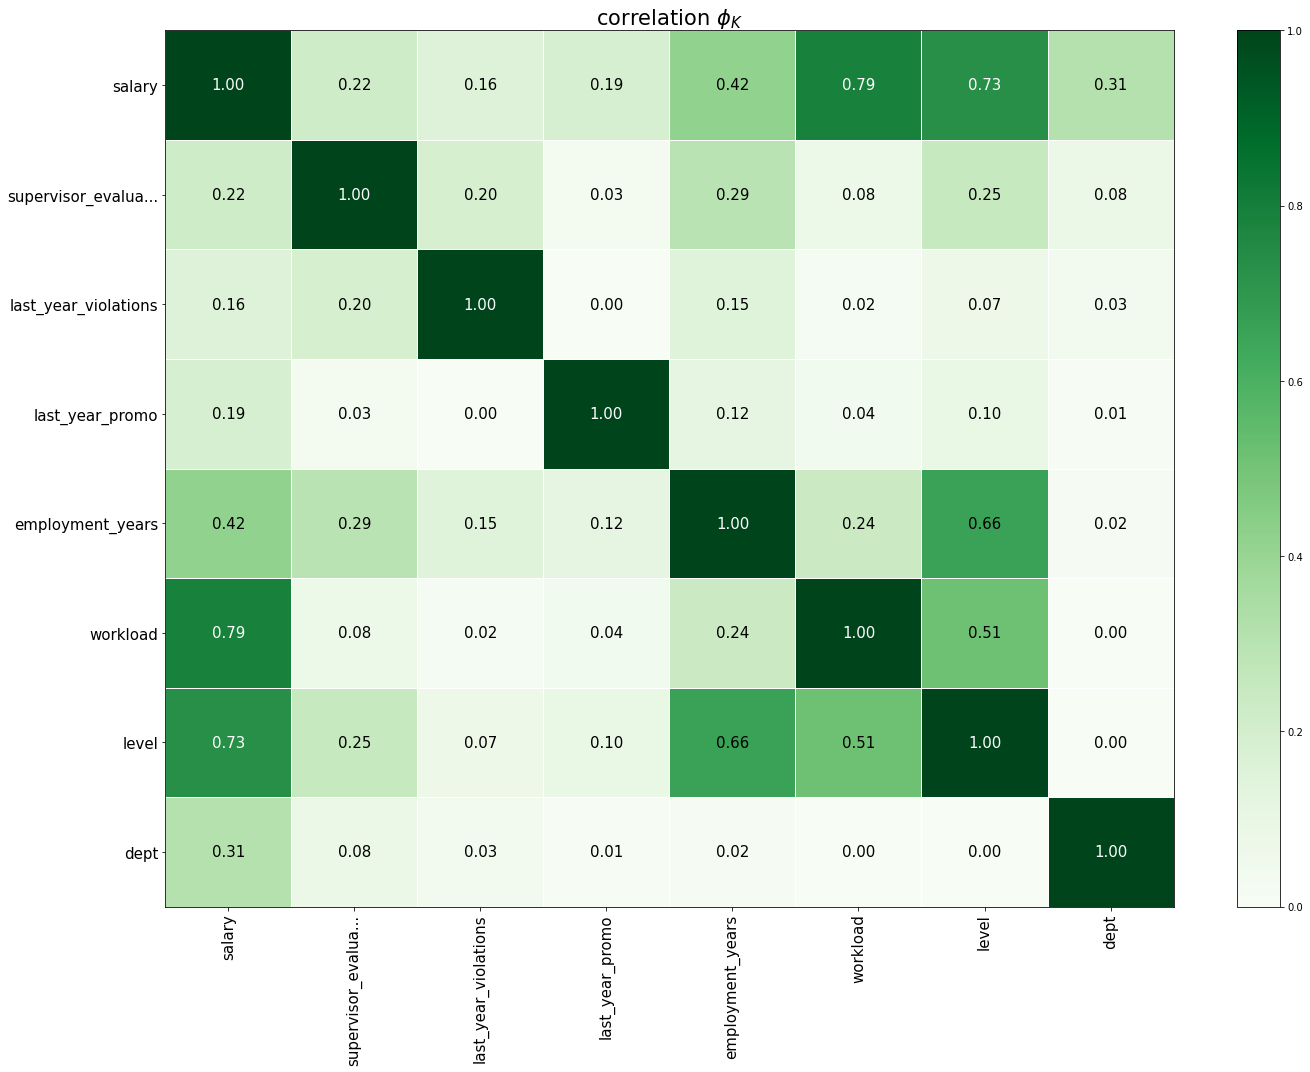

In [92]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

In [93]:
phik_overview = phik_matrix(data_q_resigned,interval_cols=interval_cols)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable quit for analysis 1. Dropping this column
  warnings.warn(


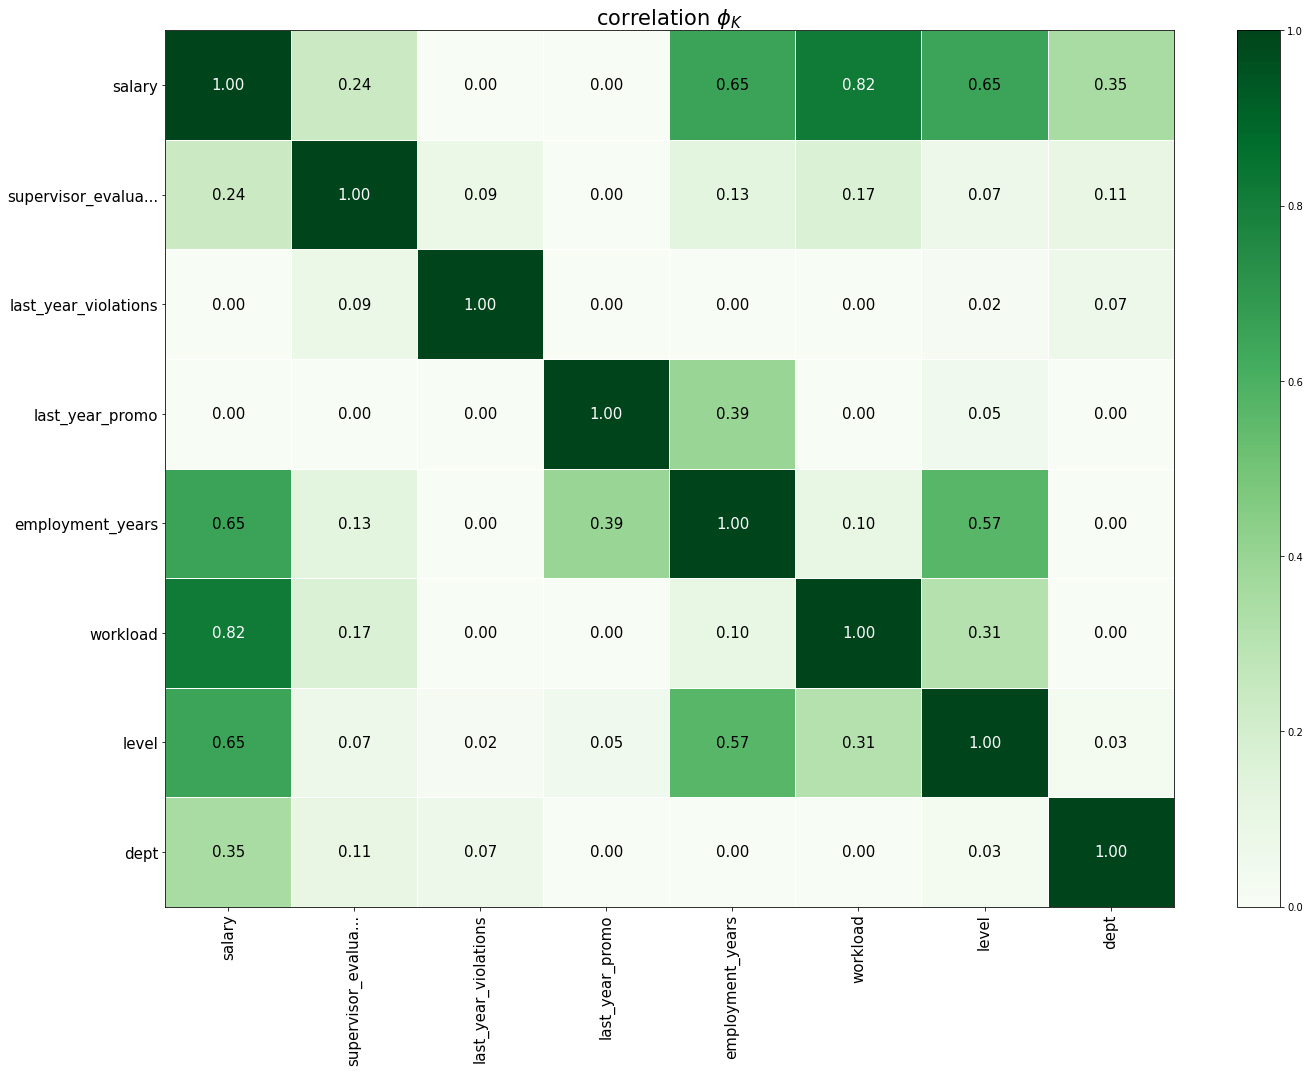

In [94]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Распределение признаков в целом схоже с предыдущими данными. Основные наблюдения:

Наблюдается значительный дисбаланс по признаку повышения сотрудников: 97.2% сотрудников не были повышены.
Только 13.6% сотрудников получили выговоры за нарушения трудового кодекса за последний год.
По текущим данным, 71.8% сотрудников не были уволены, что указывает на дисбаланс целевого признака.
Целевой признак имеет умеренно положительную корреляцию (0.5 < y < 0.8) с рядом факторов:

employment_years (0.66): Наибольшее число увольнений происходит в первые два года работы, что связано с естественной текучестью кадров.
salary (0.56): Сотрудники с низкой заработной платой, вероятно, не соответствующей их ожиданиям, чаще склонны к увольнению.
Утечка целевого признака не выявлена.

Также очевидно, что уровень заработной платы значительно зависит от загруженности сотрудника и особенностей его отдела.

# Портрет уволившегося сотрудника

In [95]:
resigned = quit_X_train.query('quit == "yes"')
not_resigned = quit_X_train.query('quit == "no"')

In [96]:
resigned.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
5,699916,sales,junior,low,1,no,yes,3,18000,yes
9,613206,technology,middle,medium,2,no,no,3,45600,yes
24,468145,technology,junior,medium,2,no,no,3,30000,yes
25,982346,marketing,junior,medium,3,no,no,3,30000,yes


In [97]:
resigned['last_year_promo'].value_counts(normalize=True)

no     0.999113
yes    0.000887
Name: last_year_promo, dtype: float64

In [98]:
resigned['dept'].value_counts(normalize=True)

sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: dept, dtype: float64

In [99]:
resigned['last_year_violations'].value_counts(normalize=True)

no     0.797872
yes    0.202128
Name: last_year_violations, dtype: float64

In [100]:
resigned['supervisor_evaluation'].value_counts(normalize=True)

3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: supervisor_evaluation, dtype: float64

In [101]:
resigned['supervisor_evaluation'].mean()

3.0460992907801416

In [102]:
not_resigned['supervisor_evaluation'].mean() - resigned['supervisor_evaluation'].mean()

0.5970065588020312

В среднем оставшийся сотрудник получает оценку на 0.6 единиц выше от руководства, чем уволившийся.

In [103]:
resigned['level'].value_counts(normalize=True)

junior    0.889184
middle    0.095745
senior    0.015071
Name: level, dtype: float64

In [104]:
resigned['employment_years'].value_counts(normalize=True)

1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
8     0.002660
9     0.002660
10    0.002660
Name: employment_years, dtype: float64

In [105]:
not_resigned['employment_years'].mean() - resigned['employment_years'].mean()

2.5858521503783165

В среднем оставшийся сотрудник работает на 2.6 года дольше уволившегося.

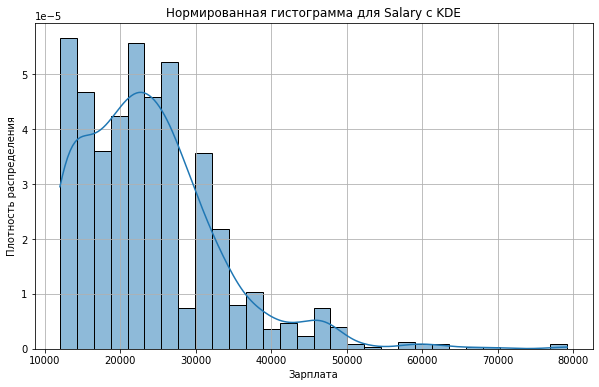

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(data=resigned, x='salary', stat='density', kde=True, common_norm=False, bins=30)
plt.title('Нормированная гистограмма для Salary с KDE')
plt.xlabel('Зарплата')
plt.ylabel('Плотность распределения')
plt.grid(True)
plt.show()

In [107]:
resigned['workload'].value_counts(normalize=True)

low       0.460106
medium    0.432624
high      0.107270
Name: workload, dtype: float64

In [108]:
print('Средняя ЗП уволившихся сотрудников:', resigned['salary'].median())
print('Средняя ЗП работающих сотрудников:', not_resigned['salary'].median())
print('Средняя разница в зарплатах:', not_resigned['salary'].median() - resigned['salary'].median())

Средняя ЗП уволившихся сотрудников: 22800.0
Средняя ЗП работающих сотрудников: 34800.0
Средняя разница в зарплатах: 12000.0


Вероятнее всего, сотрудник работает в отделе продаж (sales), занимает младшую должность (junior), имеет низкую или среднюю загрузку. Средний стаж работы составляет 1-2 года, а средний уровень заработной платы — 22 800, что на 12 000 ниже среднего показателя по компании. Доля уволившихся сотрудников составляет 28.2%. Также его не повышали за последний год, средняя оценка, которую ставили сотруднику руководители, равна 3 единицам, он по большей части не нарушал корпоративные правила.

In [109]:
target_dependence = job_y_test.merge(quit_y_test, on='id', how='left')
target_dependence.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


In [110]:
target_dependence_resigned = target_dependence.query('quit == "yes"')['job_satisfaction_rate']
target_dependence_not_resigned = target_dependence.query('quit == "no"')['job_satisfaction_rate']
display(len(target_dependence_resigned))
display(len(target_dependence_not_resigned))

564

1436

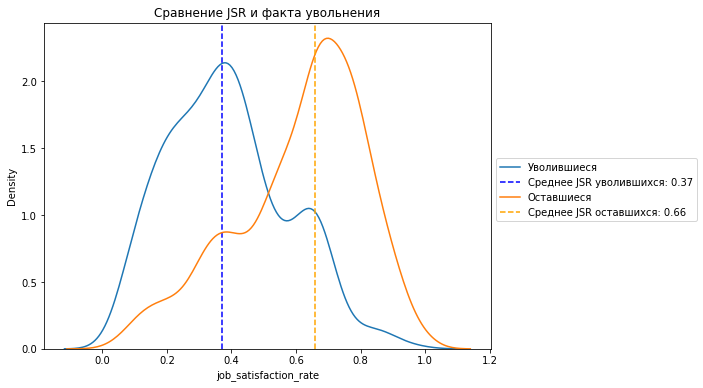

In [111]:
fig, axes = plt.subplots(figsize=(8, 6))

# График №1
sns.kdeplot(
    data=target_dependence_resigned,
    label='Уволившиеся',
    ax=axes
)

# Медиана для графика №1
mean_resigned = target_dependence_resigned.median()
axes.axvline(
    mean_resigned,
    color='blue',
    linestyle='--',
    label=f'Среднее JSR уволившихся: {mean_resigned:.2f}'
)

# График №2
sns.kdeplot(
    data=target_dependence_not_resigned,
    label='Оставшиеся',
    ax=axes
)

# Медиана для графика №2
mean_not_resigned = target_dependence_not_resigned.median()
axes.axvline(
    mean_not_resigned,
    color='orange', linestyle='--',
    label=f'Среднее JSR оставшихся: {mean_not_resigned:.2f}'
)

axes.set_title('Сравнение JSR и факта увольнения')
plt.legend(bbox_to_anchor=(1, 0.6))
plt.show()

In [112]:
shapiro_resigned = shapiro(target_dependence_resigned)
shapiro_not_resigned = shapiro(target_dependence_not_resigned)

print(f"Shapiro-Wilk тест для уволившихся: p-value = {shapiro_resigned.pvalue:.10f}")
print(f"Shapiro-Wilk тест для оставшихся: p-value = {shapiro_not_resigned.pvalue:.10f}")

if shapiro_resigned.pvalue > 0.05 and shapiro_not_resigned.pvalue > 0.05:
    t_stat, t_p_value = ttest_ind(target_dependence_resigned, target_dependence_not_resigned)
    print(f"T-test: t-статистка = {t_stat:.4f}, p-value = {t_p_value:.4f}")
else:
    u_stat, u_p_value = mannwhitneyu(target_dependence_resigned, target_dependence_not_resigned, alternative='two-sided')
    print(f"Mann-Whitney U тест: U-значение = {u_stat:.4f}, p-value = {u_p_value:.10f}")

Shapiro-Wilk тест для уволившихся: p-value = 0.0000000504
Shapiro-Wilk тест для оставшихся: p-value = 0.0000000000
Mann-Whitney U тест: U-значение = 167292.5000, p-value = 0.0000000000


p-value меньше 0.05 -> есть статистически значимые различия между группами.

In [113]:
print('Среднее JSR уволившихся сотрудников:', target_dependence_resigned.mean())
print('Среднее JSR оставшихся сотрудников:', target_dependence_not_resigned.mean())

Среднее JSR уволившихся сотрудников: 0.38771276595744686
Среднее JSR оставшихся сотрудников: 0.6120403899721449


Уровень удовлетворённости работой в компании действительно оказывает влияние на вероятность увольнения сотрудника. Средний показатель JSR у уволившихся сотрудников составляет 0.39, что почти вдвое ниже, чем у оставшихся, у которых он равен 0.61.

# Подготовка данных

In [114]:
job_X_train_merge = job_X_train.set_index('id')
job_X_train_merge.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


In [115]:
common_ids = set(quit_X_train.index).intersection(set(job_X_train_merge.index))
print("Общие 'id':", len(common_ids))

Общие 'id': 0


Поскольку общих ID сотрудников из двух тренировочных выборок не обнаружено, нам необходимо предсказать JSR для новой тренировочной выборки.

In [116]:
quit_train_JSR = grid.best_estimator_.predict(quit_X_train)
quit_train_JSR

array([0.605     , 0.84636364, 0.3375    , ..., 0.5175    , 0.55333333,
       0.53      ])

In [117]:
quit_X_train_ml = quit_X_train.copy(deep=True)
quit_X_train_ml['job_satisfaction_rate_pred'] = quit_train_JSR
quit_X_train_ml.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.605000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.337500
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


In [118]:
train_temp1 = quit_X_train_ml.drop(['id'], axis=1)
print('Количество дубликатов:',train_temp1.duplicated().sum())

Количество дубликатов: 1413


In [119]:
train_temp1 = train_temp1.drop_duplicates().reset_index(drop=True)

In [120]:
train_temp1

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,sales,middle,high,2,no,no,4,54000,no,0.605000
1,sales,junior,medium,2,no,no,4,27600,no,0.846364
2,purchasing,middle,medium,5,no,no,1,37200,no,0.337500
3,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
4,marketing,junior,medium,2,no,no,5,25200,no,0.791667
...,...,...,...,...,...,...,...,...,...,...
2582,technology,junior,low,2,no,no,4,22800,yes,0.848333
2583,marketing,junior,low,1,no,no,5,18000,no,0.830000
2584,technology,junior,high,1,no,no,4,42000,yes,0.463333
2585,purchasing,junior,low,2,no,yes,4,12000,yes,0.517500


In [121]:
job_X_test['job_satisfaction_rate_pred'] = grid.best_estimator_.predict(job_X_test)
job_X_test.head()

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  return output


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.885000
1,686555,hr,junior,medium,1,no,no,4,30000,0.682222
2,467458,sales,middle,low,5,no,no,4,19200,0.690000
3,418655,sales,middle,low,6,no,no,4,19200,0.713333
4,789145,hr,middle,medium,5,no,no,5,40800,0.812500


In [122]:
X_train1 = train_temp1.drop(['quit'], axis=1)
y_train1 = train_temp1['quit']
X_train1.shape

(2587, 9)

In [123]:
test1 = job_X_test.merge(quit_y_test, on='id')

In [124]:
X_test1_ = test1.drop(['quit','id'], axis=1)
y_test1_ = test1['quit']
X_test1_.shape

(2000, 9)

In [125]:
label_encoder = LabelEncoder()
y_train1 = label_encoder.fit_transform(y_train1)
y_test1_ = label_encoder.transform(y_test1_)

In [126]:
ohe_columns = [
    'last_year_violations', 
    'last_year_promo', 
    'dept'
]
ord_columns = [
    'level', 
    'workload' 
]
num_columns = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred'] 

In [127]:
pipe(ohe_columns, ord_columns, num_columns)

# Обучение модели

In [128]:
param_grid = [
    
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(4, 7),
        'models__max_features': range(6, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },
 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [LogisticRegression(
            random_state=42, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    },

    {
        'models': [SVC(
            random_state=42,
            kernel = 'rbf'
        )],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
    }
]

In [129]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter=20,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
randomized_search.fit(X_train1, y_train1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_violations',
                                                                                'last_year_promo',
                                                                                'dept']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'models__n_neighbors': range(2, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(random_state=42)],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=42, scoring='roc_auc')

In [130]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_violations',
                                                   'last_year_promo', 'dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [131]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__C,param_models,param_models__max_features,param_models__max_depth,param_models__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022449,0.000905,0.007892,0.000230,MinMaxScaler(),2,"LogisticRegression(penalty='l1', random_state=...",NaN,NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.918364,0.890404,0.891113,0.897102,0.912018,0.901800,0.011357,5
1,0.016842,0.000319,0.008024,0.000471,MinMaxScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",7,6,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.886599,0.891523,0.891340,0.894461,0.920115,0.896808,0.011923,11
2,0.017081,0.000418,0.017180,0.000333,MinMaxScaler(),NaN,KNeighborsClassifier(),NaN,NaN,4,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.867895,0.857345,0.866748,0.869768,0.870392,0.866430,0.004725,20
3,0.016533,0.000247,0.007671,0.000206,MinMaxScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",8,6,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.892458,0.877914,0.894603,0.878685,0.903858,0.889504,0.009921,15
4,0.016353,0.000556,0.007552,0.000226,StandardScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",7,5,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.896393,0.893741,0.905302,0.904824,0.913348,0.902722,0.006996,1
5,0.016062,0.000571,0.007653,0.000161,MinMaxScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",7,5,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.896393,0.893741,0.905302,0.904824,0.913348,0.902722,0.006996,1
6,0.072754,0.002085,0.023992,0.000537,StandardScaler(),NaN,SVC(random_state=42),NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.915577,0.892345,0.892497,0.887462,0.916874,0.900951,0.012609,8
7,0.024911,0.002747,0.007913,0.000216,StandardScaler(),1,"LogisticRegression(penalty='l1', random_state=...",NaN,NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.917952,0.890441,0.891132,0.896961,0.912440,0.901785,0.011317,6
8,0.016701,0.000166,0.007786,0.000478,StandardScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",6,6,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.886599,0.869548,0.862042,0.877782,0.915956,0.882385,0.018679,17
9,0.017309,0.001792,0.008027,0.000491,StandardScaler(),NaN,"DecisionTreeClassifier(max_depth=5, max_featur...",6,4,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.901957,0.889738,0.887978,0.908007,0.916684,0.900873,0.010884,9


In [132]:
y_test_proba = randomized_search.predict_proba(X_test1_)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test1_, y_test_proba)}')

Метрика ROC-AUC на тестовой выборке: 0.9127908986744109


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  return output


Выводы по 2 задаче: ROC-AUC на тестовой выборке составил 0.915, что опять же удовлетворяет условиям заказчика. Был описан портрет уволившегося сотрудника, предсказаны значения JSR, с помощью которого были спрогнозированы сотрудники, которые уволятся.

Мы завершили работу над второй задачей и обучили модель предсказывать, уволится сотрудник из компании или нет. Лучшей моделью для этой задачи оказалось дерево решений (точность предсказаний около 91%). Вероятно дерево решений справилось лучше других моделей из-за большей гибкости в настройке гиперпараметров.

Общие выводы
Мы проделали значительную работу над разработкой моделей для уменьшения оттока сотрудников крупной компании "Х". Процесс состоял из двух этапов: создание модели для прогнозирования уровня удовлетворённости сотрудников и модели для определения вероятности увольнения.

Первая задача: прогнозирование уровня удовлетворённости сотрудников
Подготовка данных:

Загружены данные с тренировочной выборкой (4000 строк) и тестовой выборкой (2000 строк). Были выявлены пропуски в колонках с отделом и должностью, дублей не обнаружено, форматы данных корректны.
Проверили количественные и категориальные признаки. Обнаруженные пустые значения заменены на NaN, аномалий в числовых данных не выявлено.
Анализ данных:

Исследовано распределение данных. Выбросов нет, данные выглядят достоверными. Корреляционный анализ показал отсутствие утечки целевого признака.
Обучение моделей:

Использовали линейную регрессию и дерево решений, оптимизировав гиперпараметры.
На основе метрики SMAPE лучшей оказалась модель дерева решений с глубиной 16 и числом признаков для разбиения 5. На тестовой выборке метрика подтвердила качество модели.
Вторая задача: прогнозирование увольнений сотрудников
Подготовка данных:

Загружены новые данные (тренировочная выборка – 4000 строк, тестовая – 2000 строк). Пропусков и дублей не обнаружено. Данные распределены аналогично первому этапу.
Анализ данных:

Исследовано распределение целевого признака "Увольнение". Составлен портрет "типичного" увольняющегося сотрудника: недавно работающий, с низкой загрузкой, на младшей позиции (junior), с низкой зарплатой. Также выявлена сильная корреляция между удовлетворённостью работой и увольнениями.
Обучение моделей:

Задача классификации решалась с помощью логистической регрессии, метода опорных векторов, KNN и дерева решений.
Лучшая модель – дерево решений с глубиной 5 и числом признаков для разбиения 7, показала точность около 91%. После исключения незначимых признаков (повышение, отдел, нарушение трудового договора), метрика ROC-AUC увеличилась до 0.92, а время вычислений сократилось.
Рекомендации заказчику
Чтобы уменьшить отток сотрудников, рекомендуется:

Следить за уровнем их удовлетворённости работой.
Ускорять перевод сотрудников с позиции junior на более высокие уровни.
Повышать загрузку сотрудников, что будет стимулировать рост зарплаты и удовлетворённости.